In [ ]:
!pip install opencv-python ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.0 MB/s eta 0:00:00


Make sure the following folders are correct for you.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/MyDrive/Colab Notebooks/Emotion Teller Project'

/content/drive/MyDrive/Colab Notebooks/Emotion Teller Project


We import the metadata and remove the rows of missing files.

In [ ]:
import pandas as pd
import ast
import os

ds_folder = 'Human-Group-Emotions-Labelled/'

In [ ]:


pics_df = pd.read_csv(ds_folder+'metadata.csv')
pics_df['objects'] = pics_df['objects'].apply(lambda x: ast.literal_eval(x))

# Check if the file exists for each row
pics_df['file_exists'] = pics_df['file_name'].apply(lambda x: os.path.exists(ds_folder + x))

# Drop rows where the file does not exist
pics_df = pics_df[pics_df.file_exists]
pics_df.drop(columns=['file_exists'], inplace=True)

pics_df.head()

,img_name,created_at,file_name,objects
0,35_Basketball_playingbasketball_35_185.jpg,2025-02-11T01:30:15.701989Z,35_Basketball_playingbasketball_35_185.jpg,"{'bbox': [[29.657794676806088, 19.672602976134..."
1,35_Basketball_playingbasketball_35_192.jpg,2025-02-11T01:30:45.928812Z,35_Basketball_playingbasketball_35_192.jpg,"{'bbox': [[18.832720588235293, 34.235294117647..."
2,35_Basketball_playingbasketball_35_220.jpg,2025-02-11T01:33:05.941467Z,35_Basketball_playingbasketball_35_220.jpg,"{'bbox': [[37.97071129707113, 56.0669456066945..."
3,35_Basketball_playingbasketball_35_284.jpg,2025-02-11T01:33:35.104032Z,35_Basketball_playingbasketball_35_284.jpg,"{'bbox': [[75.92156862745098, 13.5824682814302..."
4,35_Basketball_playingbasketball_35_386.jpg,2025-02-11T01:34:34.159045Z,35_Basketball_playingbasketball_35_386.jpg,"{'bbox': [[58.98039215686275, 50.4653294267898..."


In [ ]:
import cv2
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Basic train test split, with no regards for balancing or anything.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
train_df, val_df = train_test_split(pics_df, test_size=0.2, random_state=42)

In [ ]:
# Flatten the list of lists into a single list
all_emotions = [emotion for sublist in train_df['objects'].apply(lambda x: x['categories']) for emotion in sublist]

# Count the occurrences of each emotion
emotion_counts = pd.Series(all_emotions).value_counts()

print("Number of different emotions in train set:", len(emotion_counts))
display(emotion_counts)

Number of different emotions in train set: 7


,count
Neutral,397
Happy,384
Surprise,49
Sad,29
Angry,24
Fear,10
Disgust,6


In [ ]:
# Flatten the list of lists into a single list
all_emotions = [emotion for sublist in val_df['objects'].apply(lambda x: x['categories']) for emotion in sublist]

# Count the occurrences of each emotion
emotion_counts = pd.Series(all_emotions).value_counts()

print("Number of different emotions in validation set:", len(emotion_counts))
display(emotion_counts)

Number of different emotions in validation set: 6


,count
Neutral,127
Happy,49
Surprise,16
Angry,2
Sad,2
Fear,2


The emotions to be detected by the model.

In [ ]:
emo_dic = {'Neutral':0,'Happy':1,'Surprise':2,'Sad':3,'Angry':4,'Fear':5,'Disgust':6}

The following two cells, create new folders with labels and pictures for our training and validation sets according the structure required by `YOLO`.

In [ ]:
ds_dir = 'HGEL_YOLO_Dataset'
os.makedirs(ds_dir, exist_ok=True)

source = 'Human-Group-Emotions-Labelled/'
path = ds_dir + '/'

def xywh2xcycwh(x,y,w,h):
  return [x + w/2, y + h/2, w/2, h/2]

def label(item):
  objs = item['objects']
  text_label = ''
  for ind, emotion in enumerate(objs['categories']):
    x,y,w,h = np.array(objs['bbox'][ind])/100 # Unpack the list into four variables
    xc,yc,wc,hc = xywh2xcycwh(x,y,w,h) # Pass the four variables to the function
    text_label += f'{emo_dic[emotion]} {xc} {yc} {wc} {hc}\n'
  return text_label

In [ ]:
import shutil

# Create directories for train and validation images and labels
os.makedirs(path + 'images/train', exist_ok=True)
os.makedirs(path + 'labels/train', exist_ok=True)
os.makedirs(path + 'images/val', exist_ok=True)
os.makedirs(path + 'labels/val', exist_ok=True)

# Generate labels and copy images for the training set
for index, row in train_df.iterrows():
    image_name = row['file_name']
    label_content = label(row)
    with open(path + 'labels/train/' + image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(source + image_name, path + 'images/train/' + image_name)

# Generate labels and copy images for the validation set
for index, row in val_df.iterrows():
    image_name = row['file_name']
    label_content = label(row)
    with open(path + 'labels/val/' + image_name.replace('.jpg', '.txt'), 'w') as f:
        f.write(label_content)
    shutil.copy(source + image_name, path + 'images/val/' + image_name)

print("Generated label files and copied images for train and validation sets.")

Generated label files and copied images for train and validation sets.


Make sure `data.yaml` is in the `ds_folder`, this contains the structure for the train/val pictures and labels.

In [ ]:
model = YOLO('yolo11n.pt')

results = model.train(data = path+'data.yaml', imgsz=1024, epochs = 300)

Ultralytics 8.3.210 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=HGEL_YOLO_Dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

We use our model to predict on train and validation sets. Make sure you select the correct weights for the latest run.

In [ ]:
fine_tuned = YOLO('runs/detect/train4/weights/best.pt')

val_df['path_to_img'] = path+'images/val/'+val_df['file_name']

train_df['path_to_img'] = path+'images/train/'+train_df['file_name']

train_preds = fine_tuned.predict(list(train_df['path_to_img']))
val_preds = fine_tuned.predict(list(val_df['path_to_img']))


0: 1024x1024 3 Neutrals, 1.8ms
1: 1024x1024 5 Happys, 1.8ms
2: 1024x1024 1 Neutral, 2 Happys, 1.8ms
3: 1024x1024 5 Happys, 1.8ms
4: 1024x1024 6 Neutrals, 34 Happys, 1.8ms
5: 1024x1024 3 Happys, 1.8ms
6: 1024x1024 6 Neutrals, 22 Happys, 1.8ms
7: 1024x1024 1 Surprise, 1.8ms
8: 1024x1024 1 Neutral, 1.8ms
9: 1024x1024 1 Neutral, 4 Happys, 1.8ms
10: 1024x1024 5 Neutrals, 1.8ms
11: 1024x1024 21 Happys, 1.8ms
12: 1024x1024 10 Neutrals, 4 Happys, 1.8ms
13: 1024x1024 9 Happys, 1.8ms
14: 1024x1024 3 Neutrals, 7 Happys, 1.8ms
15: 1024x1024 10 Neutrals, 1.8ms
16: 1024x1024 3 Happys, 1.8ms
17: 1024x1024 2 Neutrals, 1.8ms
18: 1024x1024 4 Neutrals, 6 Happys, 1.8ms
19: 1024x1024 6 Neutrals, 2 Happys, 3 Surprises, 1.8ms
20: 1024x1024 11 Neutrals, 7 Happys, 1.8ms
21: 1024x1024 2 Neutrals, 1 Happy, 1.8ms
22: 1024x1024 1 Happy, 1.8ms
23: 1024x1024 4 Neutrals, 1.8ms
24: 1024x1024 1 Neutral, 1.8ms
25: 1024x1024 9 Neutrals, 1.8ms
26: 1024x1024 3 Neutrals, 1 Happy, 1.8ms
27: 1024x1024 1 Happy, 1.8ms
28: 1024

To see how this compares to original labelling, set `pic_id` to any index in the training dataset and run the cell below it.

In [ ]:
pic_id=50

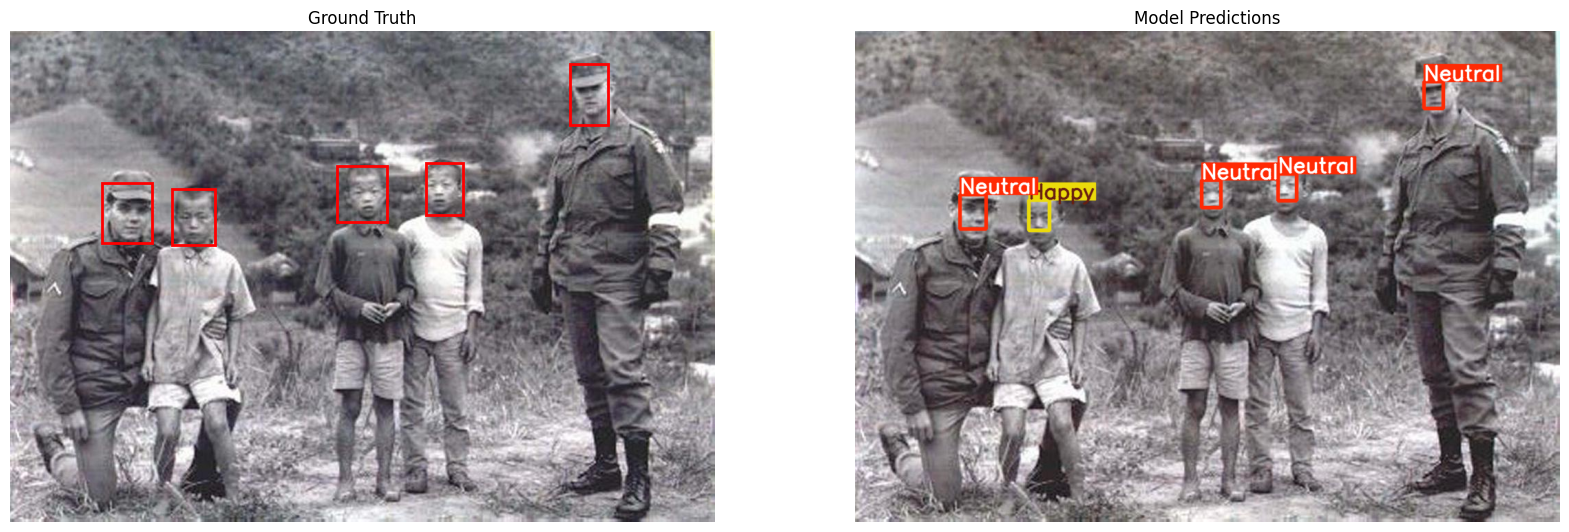

In [ ]:
# @title
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

test = train_df.iloc[pic_id]

width = test['objects']['original_width']
height = test['objects']['original_height']

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Display the original image with ground truth bounding boxes on the left subplot
axes[0].imshow(Image.open(path + 'images/train/' + test['file_name']))
axes[0].set_title('Ground Truth')
axes[0].axis("off")

for bbox in test['objects']['bbox']:
  bbox = np.array(bbox)/100
  x, y, w, h = bbox*[width,height,width,height]

  # Create a Rectangle patch
  rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

  # Add the patch to the Axes
  axes[0].add_patch(rect)

# Display the image with model predictions on the right subplot
axes[1].imshow(train_preds[pic_id].plot(conf = False, line_width = int(width*0.003))) # YOLO's plot method returns an image
axes[1].set_title('Model Predictions')
axes[1].axis("off")

plt.show()